### Importing libs, setting ipython hook

In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from utils import plot_jungfrau, combineRuns, get_tree, is_leaf, get_leaves, runNumToString, enable_underscore_cleanup, keV2Angstroms, extract_freq_component
enable_underscore_cleanup() # Sets ipython hook to delete user defined varibles that start with _ at the end of each cell execution

### Loading the data from the runs

In [15]:
###############################################
runNumbers = [64]
folder = '/sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/'
###############################################
# (1) keys_to_combine: some keys loaded for each shot & stored per shot 
# (2) keys_to_sum: some keys loaded per each run and added 
# (3) keys_to_check : check if some keys exits and have same values in all runs and load these keys 
keys_to_combine = [#'gas_detector/f_11_ENRC',
                   #'ebeam/photon_energy',
                   'evr/code_183',
                    #'evr/cod'
                   'evr/code_137',
                   'evr/code_141',
                   'lightStatus/xray',
                   #'jungfrau4M/Full_thres_sum',
                   #'feeBld/hproj',
                   'lightStatus/laser',
                   #'ipm_dg2/sum',
                    #'alvium_usr/usr_com',
                    #'alvium_usr/usr_sum',
                    'alvium_usr/usr_pj0_data',
                    'alvium_usr/usr_pj1_data',
                    #'alvium_usr/usr_downsample_data'
                  ]

keys_to_sum = [#'Sums/jungfrau4M_calib'
                ]
#               'Sums/jungfrau4M_calib_thresADU1']

keys_to_check = [
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_q',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_q',
                # 'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_idxq',
                # 'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_idxq',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbin',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbin',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbins',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbins',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_userMask',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_userMask',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_q', # This are only needed once
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_phi', # This are only needed once
                #'UserDataCfg/jungfrau4M/x',
                #'UserDataCfg/jungfrau4M/y',
                #'UserDataCfg/jungfrau4M/z',
                #'UserDataCfg/jungfrau4M/cmask'
                ]
# Load the data in
_data = combineRuns(runNumbers, folder, keys_to_combine, keys_to_sum, keys_to_check, verbose=False)  # this is the function to load the data with defined keys

xrayOn = _data['evr/code_137'].astype(bool)  # xray on events
xrayOn2 = _data['lightStatus/xray'].astype(bool)  # xray on events
laserOn = _data['lightStatus/laser'].astype(bool)  # xray on events

run_indicator = _data['run_indicator'] # run indicator for each shot
#downsampledImg = _data['alvium_usr/usr_downsample_data']
#xray_energy = _data['gas_detector/f_11_ENRC']   # xray energy from gas detector (not calibrated to actual values)
#xray_eV = _data['ebeam/photon_energy']    # x-ray energy energy in eV|
#spec = _data['feeBld/hproj'] # Shot to shot spectrometer

# New data!
aoptCam = _data['alvium_usr/usr_pj0_data'] # All optical phase tagging (AOPT alvium horizontal projection shot by shot)

Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cxi100895124_Run0064.h5
Loaded Data


### Make sure the data from the phase tagging is okay

(array([1560.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3122.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

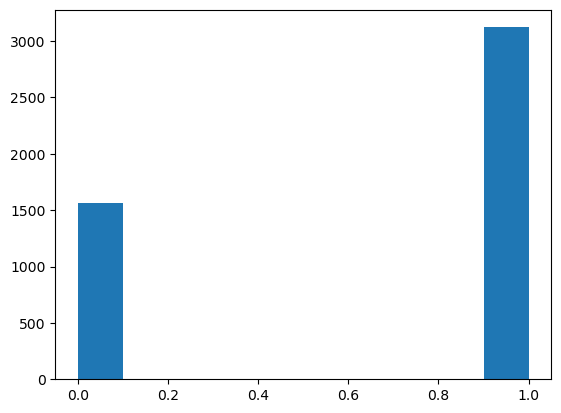

In [16]:
plt.hist(laserOn*1)

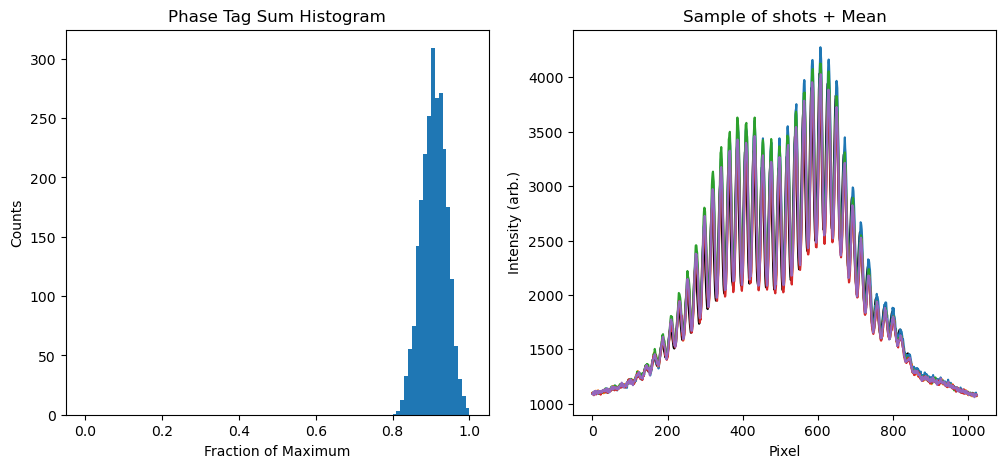

In [4]:
plt.figure(figsize=[12,5])
_aoptSum = aoptCam.sum(axis=1) # Calculate the sum of the phase tagging images
_aoptSumNorm = _aoptSum/_aoptSum.max()

plt.subplot(1,2,1)
plt.hist(_aoptSumNorm,bins=100,range=[0,1])
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')
plt.title('Phase Tag Sum Histogram')
plt.subplot(1,2,2)
plt.plot(aoptCam.mean(axis=0),color='k')
for _j in range(0,5):
    plt.plot(aoptCam[_j])
plt.xlabel('Pixel')
plt.ylabel('Intensity (arb.)')
plt.title('Sample of shots + Mean')
plt.show()


### FFTing the average. Set the bandwidth and the fs per pixel here.

Calibration parameters to enter into producer/shared mem:
Peak Location: 148.06 THz
Bandwidth: 60.00 THz
Pixel Calibration: 0.3100 fs/pix


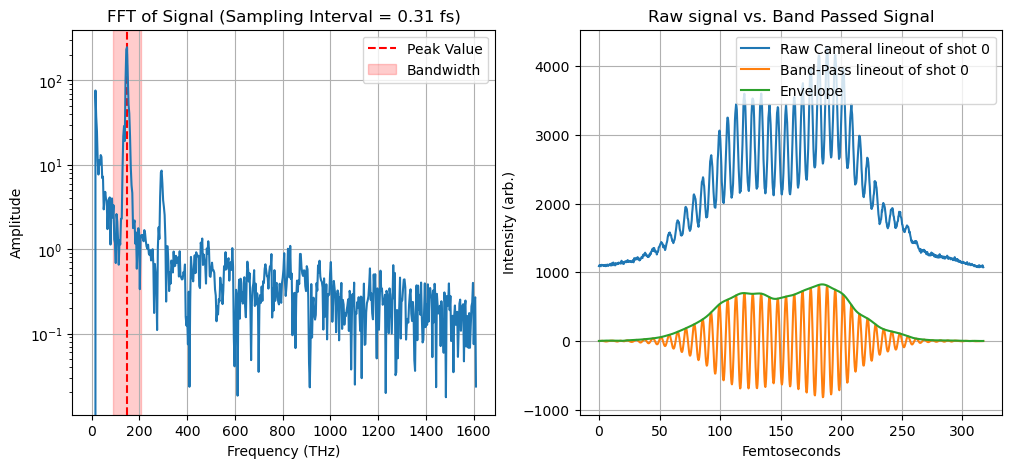

In [14]:
# Sampling interval in femtoseconds
####################
dt_fs = 0.31  # in femtoseconds
bandwidth = 60 # in THz 
####################
dt_s = dt_fs * 1e-15  # convert to seconds
# Time axis
t = np.arange(0, 1024 * dt_fs, dt_fs)  # still in fs for plotting
_signal = aoptCam.mean(axis=0)  # assume aoptCam[0] is already defined and length 1024
# Compute FFT
_N = len(t)
_fft_vals = np.fft.fft(_signal)
_fft_freqs = np.fft.fftfreq(_N, d=dt_s)  # in Hz
# Take only the positive frequencies and scale
_pos_mask = _fft_freqs >= 0
_fft_vals = _fft_vals[_pos_mask]
_fft_freqs = _fft_freqs[_pos_mask]
_fft_magnitude = np.abs(_fft_vals) * 2 / _N  # normalize amplitude
# Convert frequency axis to THz (1 THz = 1e12 Hz)
_fft_freqs_thz = _fft_freqs * 1e-12


# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.yscale('log')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title(f'FFT of Signal (Sampling Interval = {dt_fs} fs)')
plt.grid(True)

_fft_magnitude = np.where(np.arange(len(_fft_magnitude)) < 5, 0, _fft_magnitude)
peakVal = _fft_freqs_thz[_fft_magnitude.argmax()]
# peakVal = 140
filt_traces = extract_freq_component(aoptCam, 1/(dt_fs*10**-15),peakVal*10**12, bandwidth=bandwidth*10**12)
plt.axvline(peakVal, linestyle='--',color='r',label='Peak Value')
plt.axvspan(peakVal-bandwidth, peakVal+bandwidth, color='r', alpha=0.2, label='Bandwidth')
plt.plot(_fft_freqs_thz, _fft_magnitude)
plt.legend()

plt.subplot(1,2,2)
plt.plot(t, aoptCam[0],label='Raw Cameral lineout of shot 0')
plt.plot(t,filt_traces[0],label='Band-Pass lineout of shot 0');
plt.plot(t,np.abs(hilbert(filt_traces))[0],label='Envelope')
plt.xlabel('Femtoseconds')
plt.ylabel('Intensity (arb.)')
plt.title('Raw signal vs. Band Passed Signal')
plt.grid(True)
plt.legend()

print('Calibration parameters to enter into producer/shared mem:')
print(f'Peak Location: {peakVal:.2f} THz')
print(f'Bandwidth: {bandwidth:.2f} THz')
print(f'Pixel Calibration: {dt_fs:.4f} fs/pix')